In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import pandas as pd
import json
from collections import Counter

In [5]:
mut_dt = pd.read_csv('ESMC_GABPA2_mt.csv')

In [12]:
mut_dt.index = mut_dt['Unnamed: 0']

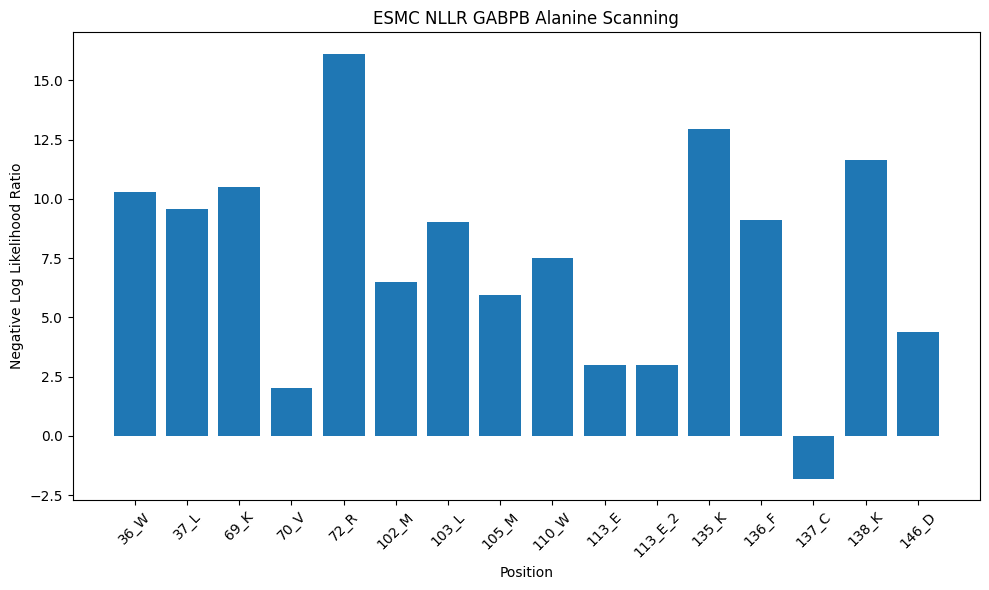

In [29]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming mut_dt is your DataFrame and 'A' is one of its index labels.
# Extract the values from the specified columns for row 'A'
selected_series = mut_dt.iloc[:, [36, 37, 69, 70, 72, 102, 103, 105, 110, 113, 113, 135, 136, 137, 138, 146]].loc['A', :]
selected_series = selected_series * -1
# Handle duplicate indices (e.g., column 113 appears twice) by appending a counter to duplicates
labels = []
counter = {}
for label in selected_series.index:
    if label in counter:
        counter[label] += 1
        labels.append(f"{label}_{counter[label]}")
    else:
        counter[label] = 1
        labels.append(label)

# Plot the values in a bar plot
plt.figure(figsize=(10, 6))
plt.bar(labels, selected_series.values)
plt.xlabel("Position")
plt.ylabel("Negative Log Likelihood Ratio")
plt.title("ESMC NLLR GABPB Alanine Scanning")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [ ]:
####################################################
# 1. Extend the model with a masking head (LM Head)
####################################################
class ESMCMasked(nn.Module):
   
    # A simple wrapper that takes a pre-trained ESM C model and adds
    # a masking (language modeling) head on top of the final hidden states.

    def __init__(self, base_model, hidden_dim=64, num_aa=33):
        super().__init__()
        self.base_model = base_model  # Pretrained ESM C model
        self.mask_head = nn.Linear(hidden_dim, num_aa)  # Simple linear LM head

    def forward(self, protein_obj, mask_positions=None):
        # Encode the protein to get initial embeddings
        encoded_seq = self.base_model.encode(protein_obj)
        # Obtain the hidden representations (logits call ensures forward pass)
        logits_out = self.base_model.logits(
            encoded_seq,
            LogitsConfig(sequence=True, return_embeddings=False)
        )
        # logits_out.logits.sequence is a list of length batch_size; here presumably 1
        # hidden has shape [L, hidden_dim] if single-sequence
        hidden = logits_out.logits.sequence[0]

        # Convert hidden from bfloat16 to float32 (match linear layer weights)
        hidden = hidden.to(self.mask_head.weight.dtype)

        # Pass through the custom LM head
        out_logits = self.mask_head(hidden)  # shape: [L, num_aa]

        if mask_positions is not None:
            # Return just the masked positions
            masked_logits = out_logits[mask_positions]
            return masked_logits, hidden
        else:
            # Or return logits for every position
            return out_logits

def load_finetuned_model(model_path, full_pretraining=False, device='cuda'):
    # Load checkpoint
    checkpoint = torch.load(model_path, map_location=device)
    config = checkpoint['config']
    
    # 1. Load base ESMC model
    base_model = ESMC.from_pretrained("esmc_300m").to(device)
    
    # 3. Wrap with ESMCMasked using saved config
    model = ESMCMasked(
        base_model,
        hidden_dim=config['hidden_dim'],
        num_aa=config['num_aa']
    ).to(device)
    
    # 4. Load trained weights
    model.load_state_dict(checkpoint['model_state_dict'])
    
    return model

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') 

In [2]:
device

device(type='cpu')

In [6]:
variants_df = pd.read_csv('/global/scratch/users/sergiomar10/data/variants/COSTELLO_VARIANTS_PT.csv')

In [7]:
variants_df = variants_df[variants_df['mutant_protein_sequence'].notna()]
variants_df['effect'] = [x[:10] for x in variants_df['top_effect']]
variants_df.head()

,Unnamed: 0.1,Unnamed: 0,patient,chrom,pos,ref,alt,qual,file,top_effect,...,mutant_protein_sequence,original_protein_sequence,Gene,Transcript,exome_lib,SF#,SF#unique,Patient,Histology,Exome
0,0,0,Patient166_mutect2,1,1495668,A,G,<pysam.libcbcf.VariantRecordInfo object at 0x7...,/costellolab/data4/LG3_hg38_output/LG4/mutatio...,"Substitution(variant=Variant(contig='1', start...",...,MSWLFGVNKGPKGEGAGPPPPLPPAQPGAEGGGDRGLGDRPAPKDK...,MSWLFGVNKGPKGEGAGPPPPLPPAQPGAEGGGDRGLGDRPAPKDK...,ATAD3B-206,ENST00000673477,Z00175,SF7924,SF7924_B1,P166,Astro,Z00175
1,1,1,Patient166_mutect2,1,1495680,T,C,<pysam.libcbcf.VariantRecordInfo object at 0x7...,/costellolab/data4/LG3_hg38_output/LG4/mutatio...,"Substitution(variant=Variant(contig='1', start...",...,MSWLFGVNKGPKGEGAGPPPPLPPAQPGAEGGGDRGLGDRPAPKDK...,MSWLFGVNKGPKGEGAGPPPPLPPAQPGAEGGGDRGLGDRPAPKDK...,ATAD3B-206,ENST00000673477,Z00175,SF7924,SF7924_B1,P166,Astro,Z00175
2,2,2,Patient166_mutect2,1,1495700,CT,C,<pysam.libcbcf.VariantRecordInfo object at 0x7...,/costellolab/data4/LG3_hg38_output/LG4/mutatio...,"FrameShift(variant=Variant(contig='1', start=1...",...,MSWLFGVNKGPKGEGAGPPPPLPPAQPGAEGGGDRGLGDRPAPKDK...,MSWLFGVNKGPKGEGAGPPPPLPPAQPGAEGGGDRGLGDRPAPKDK...,ATAD3B-206,ENST00000673477,Z00175,SF7924,SF7924_B1,P166,Astro,Z00175
3,3,3,Patient166_mutect2,1,1599372,G,A,<pysam.libcbcf.VariantRecordInfo object at 0x7...,/costellolab/data4/LG3_hg38_output/LG4/mutatio...,"Substitution(variant=Variant(contig='1', start...",...,MRAPPLLLLLAACAPPPCAAAAPTPPGWEPTPDAPWCPYKVLPEGP...,MRAPPLLLLLAACAPPPCAAAAPTPPGWEPTPDAPWCPYKVLPEGP...,FNDC10-201,ENST00000422725,Z00175,SF7924,SF7924_B1,P166,Astro,Z00175
4,4,4,Patient166_mutect2,1,1640354,C,T,<pysam.libcbcf.VariantRecordInfo object at 0x7...,/costellolab/data4/LG3_hg38_output/LG4/mutatio...,"Substitution(variant=Variant(contig='1', start...",...,MGDEKDSWKVKTLDEILQEKKRRKEQEEKAEIKRLKNSDDRDSKRD...,MGDEKDSWKVKTLDEILQEKKRRKEQEEKAEIKRLKNSDDRDSKRD...,CDK11B-203,ENST00000341832,Z00175,SF7924,SF7924_B1,P166,Astro,Z00175


In [8]:
variants_pt = variants_df.drop_duplicates('top_effect')
variants_pt['effect'].value_counts().head(10)

effect
Substituti    44481
FrameShift     8119
Deletion(v     7363
PrematureS     1196
Insertion(      856
ComplexSub      622
StopLoss(v      156
Name: count, dtype: int64

In [10]:
# # Build the mask for rows that meet your condition
# mask = (
#     ~variants_df['mutant_protein_sequence'].notna() & 
#     variants_df['mc'].str.contains('synonymous')
# )

# # Use .loc to do the assignment reliably
# variants_df.loc[mask, 'mutant_protein_sequence'] = variants_df.loc[mask, 'original_protein_sequence']

# allowed_terms = [
#     "('SO:0001819|synonymous_variant',)",
#     "('SO:0001583|missense_variant',)",
#     "('SO:0001589|frameshift_variant',)",
#     "('SO:0001587|nonsense',)",
# ]

# # filtered_df = variant',)s_df[variant',)s_df["mc"].isin(allowed_terms)]
# filtered_df = variants_df[variants_df["mc"].isin(allowed_terms)]
# filtered_df['mc'].value_counts()
# variants_df = filtered_df

In [13]:
from esm.models.esmc import ESMC
from esm.sdk.api import ESMProtein, LogitsConfig

model = load_finetuned_model(
    "/global/scratch/users/sergiomar10/models/esm_c/masking/fine_tuned/False-Full_pretraining_20000_seq_2.pt",
    full_pretraining=False,  # Must match training setting!
    device=device
)
model.eval()  # Set to evaluation mode"

/clusterfs/nilah/sergio/miniconda3/envs/ESMC2/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Fetching 4 files: 100%|██████████| 4/4 [00:00<00:00, 3392.08it/s]


ESMCMasked(
  (base_model): ESMC(
    (embed): Embedding(64, 960)
    (transformer): TransformerStack(
      (blocks): ModuleList(
        (0-29): 30 x UnifiedTransformerBlock(
          (attn): MultiHeadAttention(
            (layernorm_qkv): Sequential(
              (0): LayerNorm((960,), eps=1e-05, elementwise_affine=True)
              (1): Linear(in_features=960, out_features=2880, bias=False)
            )
            (out_proj): Linear(in_features=960, out_features=960, bias=False)
            (q_ln): LayerNorm((960,), eps=1e-05, elementwise_affine=True)
            (k_ln): LayerNorm((960,), eps=1e-05, elementwise_affine=True)
            (rotary): RotaryEmbedding()
          )
          (ffn): Sequential(
            (0): LayerNorm((960,), eps=1e-05, elementwise_affine=True)
            (1): Linear(in_features=960, out_features=5120, bias=False)
            (2): SwiGLU()
            (3): Linear(in_features=2560, out_features=960, bias=False)
          )
        )
      )
     

In [14]:
#########################################################
# 4. Define a mapping for the 20 standard amino acids
#########################################################
amino_acids = "ARNDCEQGHILKMFPSTWYV"

# Map each amino acid to its tokenizer-assigned ID
aa_to_idx = {
    aa: model.base_model.tokenizer(text=aa).input_ids[1]  # index=1 to skip <cls> or start token
    for aa in amino_acids
}
# Reverse mapping: token_id → amino acid
idx_to_aa = {idx: aa for aa, idx in aa_to_idx.items()}

print(f"aa_to_idx: {aa_to_idx}", flush=True)
print(f"idx_to_aa: {idx_to_aa}", flush=True)

aa_to_idx: {'A': 5, 'R': 10, 'N': 17, 'D': 13, 'C': 23, 'E': 9, 'Q': 16, 'G': 6, 'H': 21, 'I': 12, 'L': 4, 'K': 15, 'M': 20, 'F': 18, 'P': 14, 'S': 8, 'T': 11, 'W': 22, 'Y': 19, 'V': 7}
idx_to_aa: {5: 'A', 10: 'R', 17: 'N', 13: 'D', 23: 'C', 9: 'E', 16: 'Q', 6: 'G', 21: 'H', 12: 'I', 4: 'L', 15: 'K', 20: 'M', 18: 'F', 14: 'P', 8: 'S', 11: 'T', 22: 'W', 19: 'Y', 7: 'V'}


In [15]:
#########################################################
# Helper Functions for PLL and Effect Scores
#########################################################

def compute_pll(sequence, model, tokenizer, device, max_len=1022):
    """
    Compute the pseudo-log-likelihood (PLL) for a given protein sequence.
    PLL(s) = sum_{i in valid positions} log P(x_i = s_i | s)
    """
    protein = ESMProtein(sequence=sequence)
    protein_tensor = model.base_model.encode(protein)
    token_ids = protein_tensor.sequence  # Tensor of token IDs
    valid_positions = []
    for pos in range(1, len(token_ids) - 1):  # skip special tokens
        token_id = int(token_ids[pos].item())
        token_str = tokenizer.decode([token_id]).strip()
        if token_str in aa_to_idx:
            valid_positions.append(pos)
    if not valid_positions:
        return None  # or raise an error
    valid_positions_tensor = torch.tensor(valid_positions, device=device)
    
    with torch.no_grad():
        logits, _ = model(protein, mask_positions=valid_positions_tensor)
    log_probs = F.log_softmax(logits, dim=-1)
    
    std_aa_pairs = sorted(aa_to_idx.items(), key=lambda x: x[1])
    std_aas = [aa for aa, _ in std_aa_pairs]
    std_indices = [idx for _, idx in std_aa_pairs]
    log_probs_matrix = log_probs[:, std_indices].cpu()  # shape: (#valid_positions, 20)
    
    pll = 0.0
    # For each valid position, add the log likelihood for the observed residue.
    for i, pos in enumerate(valid_positions):
        aa = sequence[pos - 1]  # adjust for 1-indexing in tokenization
        if aa in std_aas:
            aa_idx = std_aas.index(aa)
            pll += log_probs_matrix[i, aa_idx].item()
    return pll

def get_context_window(sequence, mut_start, mut_end, max_len=1022, pre_context=511):
    """
    Extract a subsequence (window) from a long protein sequence that includes the
    indel region [mut_start, mut_end] along with pre- and post-context.
    """
    start = max(0, mut_start - pre_context)
    end = start + max_len
    if end > len(sequence):
        end = len(sequence)
        start = max(0, end - max_len)
    return sequence[start:end], start

def compute_indel_effect_score(wt_seq, mut_seq, mut_start, mut_end, model, tokenizer, device):
    """
    Compute the effect score (PLLR) for an in-frame indel.
    Returns a dictionary with:
      - 'vanilla_pllr': PLL(mutated) - PLL(WT)
      - 'weighted_pllr': (PLL(mutated)/L_mut) - (PLL(WT)/L_WT)
      - 'absolute_pllr': |PLL(mutated) - PLL(WT)|
    If the WT or mutated sequence is longer than max_len, a context window is extracted.
    """
    max_len = 1022
    # If sequences exceed model length, extract a window containing the indel region.
    if len(wt_seq) > max_len or len(mut_seq) > max_len:
        # Use the longer sequence to determine the window
        longer_seq = wt_seq if len(wt_seq) >= len(mut_seq) else mut_seq
        window, win_start = get_context_window(longer_seq, mut_start, mut_end, max_len=max_len)
        wt_window = wt_seq[win_start:win_start+len(window)]
        mut_window = mut_seq[win_start:win_start+len(window)]
    else:
        wt_window = wt_seq
        mut_window = mut_seq
    
    pll_wt = compute_pll(wt_window, model, tokenizer, device)
    pll_mut = compute_pll(mut_window, model, tokenizer, device)
    
    if pll_wt is None or pll_mut is None:
        return None

    vanilla_pllr = pll_mut - pll_wt
    wt_len = len(wt_window)
    mut_len = len(mut_window)
    weighted_pllr = (pll_mut / mut_len) - (pll_wt / wt_len) if wt_len and mut_len else None
    absolute_pllr = abs(vanilla_pllr)
    
    return {
        'vanilla_pllr': vanilla_pllr,
        'weighted_pllr': weighted_pllr,
        'absolute_pllr': absolute_pllr,
    }

def compute_stop_gain_effect(wt_seq, stop_position, model, tokenizer, device):
    """
    Compute the effect score for a stop-gain variant.
    The effect score is the lowest (most damaging) log-likelihood among the lost region.
    stop_position should be provided as a 0-indexed position where the stop gain occurs.
    """
    # Compute PLL per residue for the WT sequence.
    protein = ESMProtein(sequence=wt_seq)
    protein_tensor = model.base_model.encode(protein)
    token_ids = protein_tensor.sequence
    valid_positions = []
    per_residue_ll = []
    # Use all valid positions (skipping special tokens)
    for pos in range(1, len(token_ids) - 1):
        token_id = int(token_ids[pos].item())
        token_str = tokenizer.decode([token_id]).strip()
        if token_str in aa_to_idx:
            valid_positions.append(pos)
    if not valid_positions:
        return None
    valid_positions_tensor = torch.tensor(valid_positions, device=device)
    with torch.no_grad():
        logits, _ = model(protein, mask_positions=valid_positions_tensor)
    log_probs = F.log_softmax(logits, dim=-1)
    std_aa_pairs = sorted(aa_to_idx.items(), key=lambda x: x[1])
    std_aas = [aa for aa, _ in std_aa_pairs]
    std_indices = [idx for _, idx in std_aa_pairs]
    log_probs_matrix = log_probs[:, std_indices].cpu()  # shape: (#valid_positions, 20)
    
    # Get per-residue log likelihoods.
    for i, pos in enumerate(valid_positions):
        aa = wt_seq[pos - 1]
        if aa in std_aas:
            aa_idx = std_aas.index(aa)
            per_residue_ll.append(log_probs_matrix[i, aa_idx].item())
        else:
            per_residue_ll.append(0.0)
    
    # The lost region is everything after the stop_position.
    # (Assuming stop_position is 0-indexed relative to the WT sequence.)
    lost_region_ll = per_residue_ll[stop_position+1:]
    if lost_region_ll:
        stop_gain_score = min(lost_region_ll)
    else:
        stop_gain_score = None
    return stop_gain_score

# variants_df['annotation'] = variants_df['mc']
# variants_df['mc'] = variants_df['annotation'].str.split('|', expand = True)[1].str.replace("',)",'').str.replace('_variant','')

In [17]:
####################################
# 1) compute_pll
####################################
def compute_pll(sequence, model, tokenizer, device, max_len=1022):
    """
    Compute the pseudo-log-likelihood (PLL) for a given protein sequence using
    an all-masked approach. Summation of log P(observed_aa | masked_input).
    """

    # Build the model-specific protein object
    protein = ESMProtein(sequence=sequence)
    protein_tensor = model.base_model.encode(protein)
    token_ids = protein_tensor.sequence  # e.g., [CLS] + actual AAs + [EOS]

    valid_positions = []
    for pos in range(1, len(token_ids) - 1):
        token_id = int(token_ids[pos].item())
        token_str = tokenizer.decode([token_id]).strip()
        if token_str in aa_to_idx:
            valid_positions.append(pos)

    if not valid_positions:
        return None

    valid_positions_tensor = torch.tensor(valid_positions, device=device)

    # Single forward pass with all valid positions masked
    with torch.no_grad():
        logits, _ = model(protein, mask_positions=valid_positions_tensor)
    log_probs = F.log_softmax(logits, dim=-1)

    # Re-map logits to the standard 20 amino acids
    std_aa_pairs = sorted(aa_to_idx.items(), key=lambda x: x[1])
    std_aas = [aa for aa, _ in std_aa_pairs]
    std_indices = [idx for _, idx in std_aa_pairs]
    log_probs_matrix = log_probs[:, std_indices].cpu()  # shape: (#valid_positions, 20)

    pll = 0.0
    # For each valid position, add log-prob of the actual residue
    for i, pos in enumerate(valid_positions):
        aa = sequence[pos - 1]  # adjusting for leading [CLS]
        if aa in std_aas:
            aa_idx = std_aas.index(aa)
            pll += log_probs_matrix[i, aa_idx].item()

    return pll

####################################
# 2) get_context_window
####################################
def get_context_window(sequence, mut_start, mut_end, max_len=1022, pre_context=511):
    """
    Extract a subsequence from 'sequence' that includes the region [mut_start, mut_end]
    plus up to 'pre_context' residues before. Ensures the total length does not exceed max_len.
    """
    start = max(0, mut_start - pre_context)
    end = start + max_len
    if end > len(sequence):
        end = len(sequence)
        start = max(0, end - max_len)
    return sequence[start:end], start

####################################
# 3) compute_stop_gain_effect
####################################
def compute_stop_gain_effect(wt_seq, stop_position, model, tokenizer, device):
    """
    Compute a single numeric measure of how damaging a premature stop is.
    We do one forward pass on the WT sequence. Then for each position in the
    lost region (i.e. after 'stop_position'), we compute the worst-case LLR
    vs. the WT residue.
    """

    protein = ESMProtein(sequence=wt_seq)
    protein_tensor = model.base_model.encode(protein)
    token_ids = protein_tensor.sequence

    # Identify valid positions
    valid_positions = []
    for pos in range(1, len(token_ids) - 1):
        token_id = int(token_ids[pos].item())
        token_str = tokenizer.decode([token_id]).strip()
        if token_str in aa_to_idx:
            valid_positions.append(pos)
    if not valid_positions:
        return None
    valid_positions_tensor = torch.tensor(valid_positions, device=device)

    # Forward pass
    with torch.no_grad():
        logits, _ = model(protein, mask_positions=valid_positions_tensor)
    log_probs = F.log_softmax(logits, dim=-1)

    # Map to 20 standard AAs
    std_aa_pairs = sorted(aa_to_idx.items(), key=lambda x: x[1])
    std_aas = [aa for aa, _ in std_aa_pairs]
    std_indices = [idx for _, idx in std_aa_pairs]
    log_probs_matrix = log_probs[:, std_indices].cpu()

    # Identify the index in valid_positions that corresponds to stop_position
    # We consider the region *after* stop_position as 'lost'
    if (stop_position + 1) < valid_positions[0] or (stop_position + 1) > valid_positions[-1]:
        return None  # The stop position is out of range for this model's valid positions
    # If you want to include the exact stop_position in "lost region", use >=
    stop_idx = next(i for i, vp in enumerate(valid_positions) if vp > stop_position)

    llrs = []
    # Iterate from stop_idx to end
    for i in range(stop_idx, len(valid_positions)):
        wt_aa = wt_seq[valid_positions[i] - 1]
        if wt_aa not in std_aas:
            continue
        wt_idx = std_aas.index(wt_aa)
        wt_log_prob = log_probs_matrix[i, wt_idx].item()

        # Compare vs. each alternative AA
        for alt_idx, alt_aa in enumerate(std_aas):
            if alt_aa == wt_aa:
                continue
            alt_log_prob = log_probs_matrix[i, alt_idx].item()
            llr = alt_log_prob - wt_log_prob
            llrs.append(llr)

    # Return the minimum (most negative) LLR as the "score"
    return min(llrs) if llrs else None

####################################
# 4) compute_frameshift_effect_local
####################################
def compute_frameshift_effect_local(wt_seq, mut_seq, mut_start, model, tokenizer, device, window_size=300):
    """
    Compare the local region (length=window_size or until sequence ends)
    starting at 'mut_start' in both WT and frameshift mutant. Return the difference
    in PLL of those windows.
    """

    # Protect against out-of-range
    if mut_start >= len(wt_seq) or mut_start >= len(mut_seq):
        return None  # The frameshift start is at or beyond the end

    region_length = min(len(wt_seq) - mut_start, len(mut_seq) - mut_start, window_size)
    wt_region = wt_seq[mut_start : mut_start + region_length]
    mut_region = mut_seq[mut_start : mut_start + region_length]

    wt_pll = compute_pll(wt_region, model, tokenizer, device, max_len=region_length)
    mut_pll = compute_pll(mut_region, model, tokenizer, device, max_len=region_length)

    if wt_pll is None or mut_pll is None:
        return None

    # The frameshift effect score (PLLR)
    return (mut_pll - wt_pll)

In [11]:
allowed_terms = [
    "Substituti",
    "PrematureS",
    "FrameShift",
    "Insertion(",
    "Deletion(",
]

# filtered_df = variant',)s_df[variant',)s_df["mc"].isin(allowed_terms)]
filtered_df = variants_pt[variants_pt["effect"].isin(allowed_terms)]
filtered_df['effect'].value_counts()

effect
Substituti    44481
FrameShift     8119
PrematureS     1196
Insertion(      856
Name: count, dtype: int64

In [19]:
####################################
# 1) compute_pll
####################################
def compute_pll(sequence, model, tokenizer, device, max_len=1022):
    """
    Compute the pseudo-log-likelihood (PLL) for a given protein sequence using
    an all-masked approach. Summation of log P(observed_aa | masked_input).
    """

    # Build the model-specific protein object
    protein = ESMProtein(sequence=sequence)
    protein_tensor = model.base_model.encode(protein)
    token_ids = protein_tensor.sequence  # e.g., [CLS] + actual AAs + [EOS]

    valid_positions = []
    for pos in range(1, len(token_ids) - 1):
        token_id = int(token_ids[pos].item())
        token_str = tokenizer.decode([token_id]).strip()
        if token_str in aa_to_idx:
            valid_positions.append(pos)

    if not valid_positions:
        return None

    valid_positions_tensor = torch.tensor(valid_positions, device=device)

    # Single forward pass with all valid positions masked
    with torch.no_grad():
        logits, _ = model(protein, mask_positions=valid_positions_tensor)
    log_probs = F.log_softmax(logits, dim=-1)

    # Re-map logits to the standard 20 amino acids
    std_aa_pairs = sorted(aa_to_idx.items(), key=lambda x: x[1])
    std_aas = [aa for aa, _ in std_aa_pairs]
    std_indices = [idx for _, idx in std_aa_pairs]
    log_probs_matrix = log_probs[:, std_indices].cpu()  # shape: (#valid_positions, 20)

    pll = 0.0
    # For each valid position, add log-prob of the actual residue
    for i, pos in enumerate(valid_positions):
        aa = sequence[pos - 1]  # adjusting for leading [CLS]
        if aa in std_aas:
            aa_idx = std_aas.index(aa)
            pll += log_probs_matrix[i, aa_idx].item()

    return pll

####################################
# 2) get_context_window
####################################
def get_context_window(sequence, mut_start, mut_end, max_len=1022, pre_context=511):
    """
    Extract a subsequence from 'sequence' that includes the region [mut_start, mut_end]
    plus up to 'pre_context' residues before. Ensures the total length does not exceed max_len.
    """
    start = max(0, mut_start - pre_context)
    end = start + max_len
    if end > len(sequence):
        end = len(sequence)
        start = max(0, end - max_len)
    return sequence[start:end], start

####################################
# 3) compute_stop_gain_effect
####################################
def compute_stop_gain_effect(wt_seq, stop_position, model, tokenizer, device):
    """
    Compute a single numeric measure of how damaging a premature stop is.
    We do one forward pass on the WT sequence. Then for each position in the
    lost region (i.e. after 'stop_position'), we compute the worst-case LLR
    vs. the WT residue.
    """

    protein = ESMProtein(sequence=wt_seq)
    protein_tensor = model.base_model.encode(protein)
    token_ids = protein_tensor.sequence

    # Identify valid positions
    valid_positions = []
    for pos in range(1, len(token_ids) - 1):
        token_id = int(token_ids[pos].item())
        token_str = tokenizer.decode([token_id]).strip()
        if token_str in aa_to_idx:
            valid_positions.append(pos)
    if not valid_positions:
        return None
    valid_positions_tensor = torch.tensor(valid_positions, device=device)

    # Forward pass
    with torch.no_grad():
        logits, _ = model(protein, mask_positions=valid_positions_tensor)
    log_probs = F.log_softmax(logits, dim=-1)

    # Map to 20 standard AAs
    std_aa_pairs = sorted(aa_to_idx.items(), key=lambda x: x[1])
    std_aas = [aa for aa, _ in std_aa_pairs]
    std_indices = [idx for _, idx in std_aa_pairs]
    log_probs_matrix = log_probs[:, std_indices].cpu()

    # Identify the index in valid_positions that corresponds to stop_position
    # We consider the region *after* stop_position as 'lost'
    if (stop_position + 1) < valid_positions[0] or (stop_position + 1) > valid_positions[-1]:
        return None  # The stop position is out of range for this model's valid positions
    # If you want to include the exact stop_position in "lost region", use >=
    stop_idx = next(i for i, vp in enumerate(valid_positions) if vp > stop_position)

    llrs = []
    # Iterate from stop_idx to end
    for i in range(stop_idx, len(valid_positions)):
        wt_aa = wt_seq[valid_positions[i] - 1]
        if wt_aa not in std_aas:
            continue
        wt_idx = std_aas.index(wt_aa)
        wt_log_prob = log_probs_matrix[i, wt_idx].item()

        # Compare vs. each alternative AA
        for alt_idx, alt_aa in enumerate(std_aas):
            if alt_aa == wt_aa:
                continue
            alt_log_prob = log_probs_matrix[i, alt_idx].item()
            llr = alt_log_prob - wt_log_prob
            llrs.append(llr)

    # Return the minimum (most negative) LLR as the "score"
    return min(llrs) if llrs else None

####################################
# 4) compute_frameshift_effect_local
####################################
def compute_frameshift_effect_local(wt_seq, mut_seq, mut_start, model, tokenizer, device, window_size=300):
    """
    Compare the local region (length=window_size or until sequence ends)
    starting at 'mut_start' in both WT and frameshift mutant. Return the difference
    in PLL of those windows.
    """

    # Protect against out-of-range
    if mut_start >= len(wt_seq) or mut_start >= len(mut_seq):
        return None  # The frameshift start is at or beyond the end

    region_length = min(len(wt_seq) - mut_start, len(mut_seq) - mut_start, window_size)
    wt_region = wt_seq[mut_start : mut_start + region_length]
    mut_region = mut_seq[mut_start : mut_start + region_length]

    wt_pll = compute_pll(wt_region, model, tokenizer, device, max_len=region_length)
    mut_pll = compute_pll(mut_region, model, tokenizer, device, max_len=region_length)

    if wt_pll is None or mut_pll is None:
        return None

    # The frameshift effect score (PLLR)
    return (mut_pll - wt_pll)

In [20]:
import traceback

# File to store the checkpoint (last processed index)
checkpoint_file = '/global/scratch/users/sergiomar10/data/checkpoint_variants.txt'

# Determine the starting index from the checkpoint file
try:
    with open(checkpoint_file, 'r') as f:
        start_index = int(f.read().strip())
except Exception:
    start_index = 0  # start from the beginning if checkpoint not available

results = []
tokenizer = model.base_model.tokenizer

# Process a subset of rows, e.g. tail(1000) or a slice of your dataframe
# Here, we resume processing from start_index to the end of the dataframe.
for idx, row in filtered_df.iloc[start_index:].iterrows():
    try:
        classification = row.get("effect", "missense")
        mutant_seq = row['mutant_protein_sequence']
        orig_seq = row['original_protein_sequence']
        gene_name = row["Gene"]
        mut_start = row.get("aa_mutation_start_offset", None)

        if classification in ["Substituti", "synonymous"]:
            wt_pll = compute_pll(orig_seq, model, tokenizer, device)
            mut_pll = compute_pll(mutant_seq, model, tokenizer, device)
            pllr = None
            if (wt_pll is not None) and (mut_pll is not None):
                pllr = mut_pll - wt_pll
            results.append({
                "protein": gene_name,
                "classification": classification,
                "pllr": pllr,
                "orig_seq": orig_seq,
                "mut_seq": mutant_seq
            })

        elif classification == "PrematureS":
            stop_position = row["aa_mutation_start_offset"]
            stop_gain_score = compute_stop_gain_effect(
                orig_seq, stop_position, model, tokenizer, device
            )
            results.append({
                "protein": gene_name,
                "classification": classification,
                "stop_position": stop_position,
                "stop_gain_score": stop_gain_score
            })

        elif (classification.startswith("Deletion") or
              classification.startswith("Insertion") or
              classification.startswith("FrameShift")):

            mut_start = row.get("aa_mutation_start_offset", None)
            if mut_start is None:
                results.append({
                    "protein": gene_name,
                    "error": "Missing aa_mutation_start_offset for indel"
                })
                continue
            mut_start = int(mut_start)

            len_diff = len(mutant_seq) - len(orig_seq)
            if len_diff % 3 != 0:
                frameshift_score = compute_frameshift_effect_local(
                    orig_seq, mutant_seq, mut_start, model, tokenizer, device
                )
                results.append({
                    "protein": gene_name,
                    "classification": classification,
                    "frameshift_score": frameshift_score
                })
            else:
                wt_pll = compute_pll(orig_seq, model, tokenizer, device)
                mut_pll = compute_pll(mutant_seq, model, tokenizer, device)
                inframe_score = None
                if wt_pll is not None and mut_pll is not None:
                    inframe_score = mut_pll - wt_pll
                results.append({
                    "protein": gene_name,
                    "classification": classification,
                    "inframe_score": inframe_score
                })

        elif classification == "StopLoss":
            old_stop = len(orig_seq)
            new_tail = mutant_seq[old_stop:]
            new_tail_pll = compute_pll(new_tail, model, tokenizer, device)
            results.append({
                "protein": gene_name,
                "classification": classification,
                "new_tail_pll": new_tail_pll,
                "original_protein_sequence": orig_seq,
                "mutant_protein_sequence": mutant_seq,
            })

        else:
            results.append({
                "protein": gene_name,
                "error": f"Unknown effect classification: {classification}"
            })

        # Optionally: periodically save progress (every N rows)
        if idx % 100 == 0:
            # Save checkpoint and intermediate results
            with open(checkpoint_file, 'w') as f:
                f.write(str(idx))
            variant_df = pd.DataFrame(results)
            variant_df.to_csv(f'/global/scratch/users/sergiomar10/data/variants_costello_seq_checkpoint_{idx}.csv', index=False)
            print(f"Processed up to row {idx}")

    except Exception as e:
        # Save current progress and print error with file information
        with open(checkpoint_file, 'w') as f:
            f.write(str(idx))
        variant_df = pd.DataFrame(results)
        variant_df.to_csv(f'/global/scratch/users/sergiomar10/variants_costello_seq_{idx}.csv', index=False)
        print(f"Error at row {idx} in variant: {e}")
        traceback.print_exc()
        # Optionally exit or continue processing
        break

# After finishing, you might want to clear the checkpoint or mark completion.
print("Processing complete.")

Processed up to row 1100
Processed up to row 1300
Processed up to row 1400
Processed up to row 1500
Processed up to row 1600
Processed up to row 1700
Processed up to row 1800
Processed up to row 1900
Error at row 2078 in variant: CUDA out of memory. Tried to allocate 11.76 GiB. GPU 0 has a total capacity of 10.91 GiB of which 8.80 GiB is free. Including non-PyTorch memory, this process has 2.11 GiB memory in use. Of the allocated memory 1.68 GiB is allocated by PyTorch, and 279.69 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)
Processing complete.


Traceback (most recent call last):
  File "/tmp/ipykernel_448069/3293997216.py", line 28, in <module>
    wt_pll = compute_pll(orig_seq, model, tokenizer, device)
  File "/tmp/ipykernel_448069/2543375364.py", line 29, in compute_pll
    logits, _ = model(protein, mask_positions=valid_positions_tensor)
  File "/clusterfs/nilah/sergio/miniconda3/envs/ESMC2/lib/python3.10/site-packages/torch/nn/modules/module.py", line 1739, in _wrapped_call_impl
    return self._call_impl(*args, **kwargs)
  File "/clusterfs/nilah/sergio/miniconda3/envs/ESMC2/lib/python3.10/site-packages/torch/nn/modules/module.py", line 1750, in _call_impl
    return forward_call(*args, **kwargs)
  File "/tmp/ipykernel_448069/1438179990.py", line 26, in forward
    logits_out = self.base_model.logits(
  File "/clusterfs/nilah/sergio/miniconda3/envs/ESMC2/lib/python3.10/site-packages/esm/models/esmc.py", line 210, in logits
    output = self.forward(sequence_tokens=input.sequence)
  File "/clusterfs/nilah/sergio/miniconda

In [2]:
import numpy as np
import matplotlib.pyplot as plt
# import seaborn as sns
import pandas as pd

In [3]:
results_dt = pd.read_csv('/global/scratch/users/sergiomar10/jupyter_notebooks/ESM_COSTELLO_VARIANTS3.csv')

In [13]:
# results_dt = pd.DataFrame(results) # results_dt.to_csv('ESM_COSTELLO_VARIANTS3.csv')

In [9]:
processed_missense_var = variants_df[variants_df['mutant_protein_sequence'].isin(results_dt['mut_seq'].values)] #.groupby('Gene')['Patient'].size().reset_index().sort_values(by='Patient', ascending = False).head(20)
processed_missense_var.drop_duplicates('Patient').groupby('mutant_protein_sequence')['Patient'].size().reset_index().sort_values(by='Patient', ascending = False)

,mutant_protein_sequence,Patient
1,MGGAVSAGEDNDDLIDNLKEAQYIRTERVEQAFRAIDRGDYYLEGY...,4
6,MTPVRMQHSLAGQTYAVPFIQPDLRREEAVQQMADALQYLQKVSGD...,4
5,MSLLTNYEGLRHQIERLVRENEELKKLVRLIRENHELKSAIKTQAG...,2
2,MHMRETSGFTLKKGRSAPLVFHPPDALIAVPFDDDDKIVGGYTCEE...,1
0,MGGAVSAGEDNDDLIDNLKEAQYIRTERVEQAFRAIDRGDYYLEGY...,1
4,MSLLTNYEGLRHQIERLVRENEELKKLVRLIRENHELKSAIKTQAG...,1
3,MLPAVGSVDEEEDPAEEDCPELVPIETTQSEEEEKSGLGAKIPVTI...,1


In [10]:
merged_df = processed_missense_var.merge(
    results_dt[['mut_seq', 'pllr']],
    left_on='mutant_protein_sequence',
    right_on='mut_seq',
    how='left'
)
merged_df

,Unnamed: 0.1,Unnamed: 0,patient,chrom,pos,ref,alt,qual,file,top_effect,...,Gene,Transcript,exome_lib,SF#,SF#unique,Patient,Histology,Exome,mut_seq,pllr
0,1040,1040,Patient166_mutect2,8,51820443,C,T,<pysam.libcbcf.VariantRecordInfo object at 0x7...,/costellolab/data4/LG3_hg38_output/LG4/mutatio...,"Substitution(variant=Variant(contig='8', start...",...,PCMTD1-201,ENST00000360540,Z00175,SF7924,SF7924_B1,P166,Astro,Z00175,MGGAVSAGEDNDDLIDNLKEAQYIRTERVEQAFRAIDRGDYYLEGY...,-6.067413
1,1041,1041,Patient166_mutect2,8,51820682,C,T,<pysam.libcbcf.VariantRecordInfo object at 0x7...,/costellolab/data4/LG3_hg38_output/LG4/mutatio...,"Substitution(variant=Variant(contig='8', start...",...,PCMTD1-201,ENST00000360540,Z00175,SF7924,SF7924_B1,P166,Astro,Z00175,MGGAVSAGEDNDDLIDNLKEAQYIRTERVEQAFRAIDRGDYYLEGY...,-1.999776
2,1042,1042,Patient166_mutect2,8,52165202,G,A,<pysam.libcbcf.VariantRecordInfo object at 0x7...,/costellolab/data4/LG3_hg38_output/LG4/mutatio...,"Substitution(variant=Variant(contig='8', start...",...,ST18-201,ENST00000276480,Z00175,SF7924,SF7924_B1,P166,Astro,Z00175,MDAEAEDKTLRTRSKGTEVPMDSLIQELSVAYDCSMAKKRTAEDQA...,0.026722
3,1043,1043,Patient166_mutect2,8,53229640,C,T,<pysam.libcbcf.VariantRecordInfo object at 0x7...,/costellolab/data4/LG3_hg38_output/LG4/mutatio...,"Substitution(variant=Variant(contig='8', start...",...,OPRK1-205,ENST00000612786,Z00175,SF7924,SF7924_B1,P166,Astro,Z00175,MKTATNIYIFNLALADALVTTTMPFQSTVYLMNSWPFGDVLCKIVI...,-3.659525
4,1046,1046,Patient166_mutect2,8,62579551,G,A,<pysam.libcbcf.VariantRecordInfo object at 0x7...,/costellolab/data4/LG3_hg38_output/LG4/mutatio...,"Substitution(variant=Variant(contig='8', start...",...,NKAIN3-202,ENST00000523211,Z00175,SF7924,SF7924_B1,P166,Astro,Z00175,MGCCTGRCSLICLCALQLVSALKRQIFDFLGFQWAPILGNFLHIIV...,-9.190152
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11426,517963,534764,Patient83_mutect2.XZ,16,2115394,G,A,<pysam.libcbcf.VariantRecordInfo object at 0x7...,/costellolab/data4/LG3_hg38_output/LG4/mutatio...,"Substitution(variant=Variant(contig='16', star...",...,PKD1-201,ENST00000262304,Z00435,SF9892,SF9892-Y&SF9892-Y-2,P83,Oligo,Z00435,MPPAAPARLALALGLGLWLGALAGGPGRGCGPCEPPCLCGPAPGAA...,-2.995738
11427,517971,534772,Patient83_mutect2.XZ,16,14889192,A,T,<pysam.libcbcf.VariantRecordInfo object at 0x7...,/costellolab/data4/LG3_hg38_output/LG4/mutatio...,"Substitution(variant=Variant(contig='16', star...",...,NOMO1-208,ENST00000620755,Z00435,SF9892,SF9892-Y&SF9892-Y-2,P83,Oligo,Z00435,MLVGQGAGPLGPAVVTAAVVLLLSGVGPAHGSEDIVVGCGGFVKSD...,-1.412349
11428,518004,534805,Patient83_mutect2.XZ,16,74391563,A,G,<pysam.libcbcf.VariantRecordInfo object at 0x7...,/costellolab/data4/LG3_hg38_output/LG4/mutatio...,"Substitution(variant=Variant(contig='16', star...",...,NPIPB15-201,ENST00000429990,Z00435,SF9892,SF9892-Y&SF9892-Y-2,P83,Oligo,Z00435,MRLRFWLLIWLLLGFISHQPTPVINSLAVYRHRETDFGVGVRDHPG...,1.797713
11429,518027,534828,Patient83_mutect2.XZ,17,15619445,A,T,<pysam.libcbcf.VariantRecordInfo object at 0x7...,/costellolab/data4/LG3_hg38_output/LG4/mutatio...,"Substitution(variant=Variant(contig='17', star...",...,CDRT1-204,ENST00000395906,Z00435,SF9892,SF9892-Y&SF9892-Y-2,P83,Oligo,Z00435,MENLESRLKNAPYFRCEKGTDSNPLCRKCETRVLAWKIFSTKEWFC...,1.639790


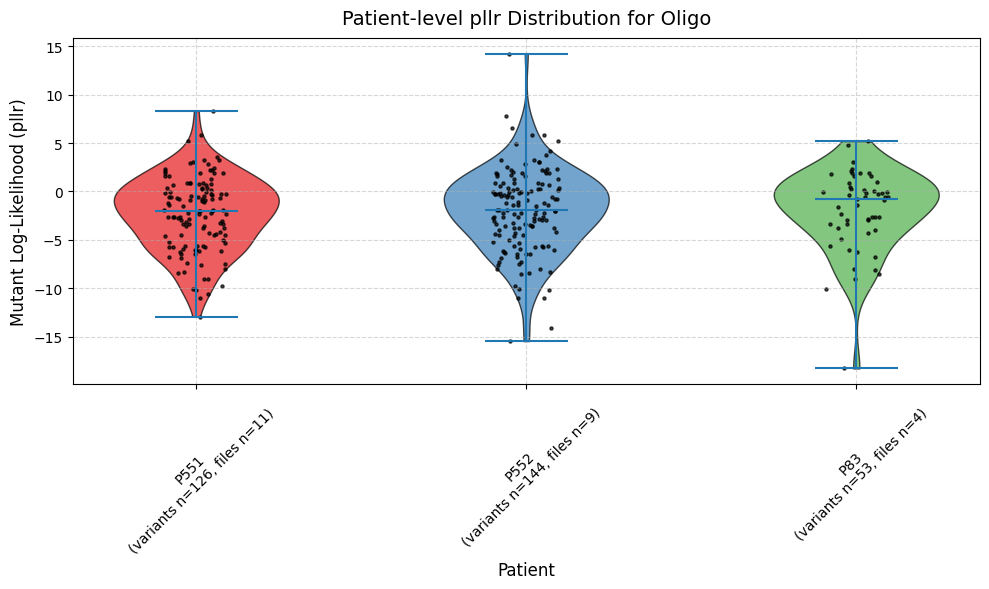

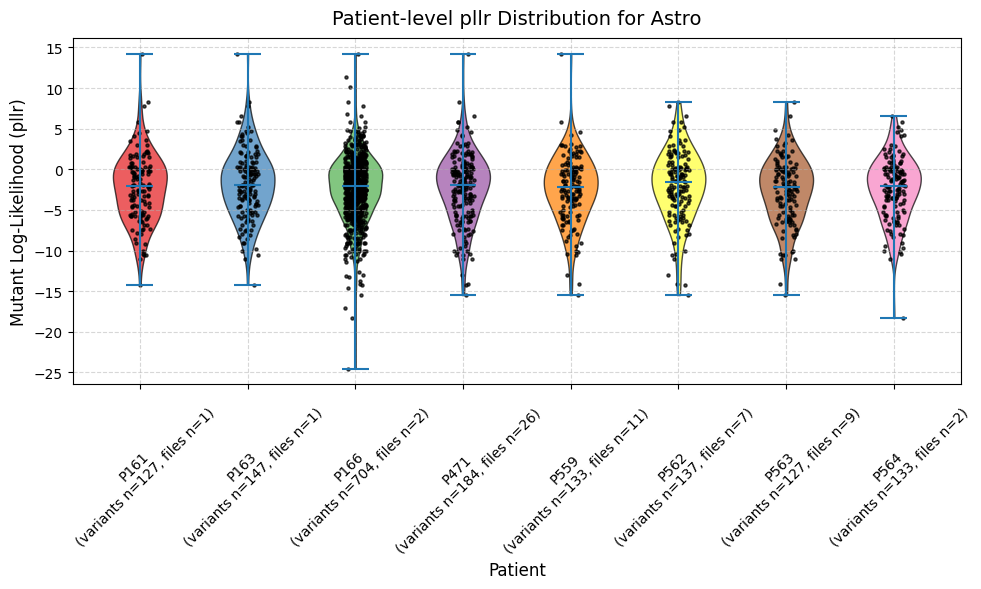

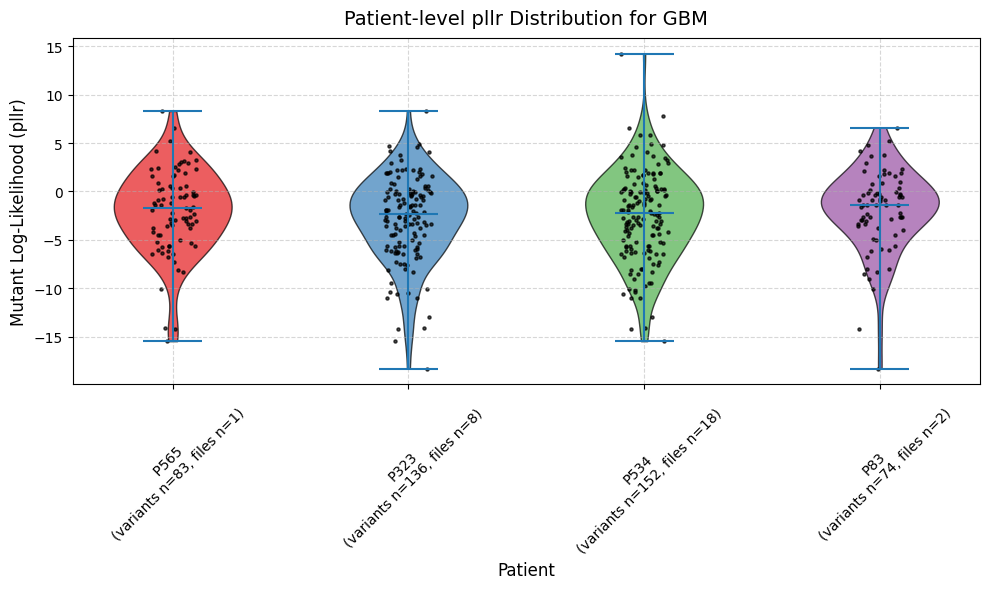

In [11]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# --- Plot per Histology ---
# Define the histology groups of interest.
histologies = ['Oligo', 'Astro', 'GBM']

for hist in histologies:
    # Filter for the current histology using case-insensitive matching.
    hist_data = merged_df[merged_df['Histology'].str.contains(hist, case=False, na=False)]


    # Get the sorted list of unique patients in this histology group.
    patients = np.sort(hist_data['Patient'].unique())
    
    # Prepare the data and x-axis labels:
    # For each patient, get the list of pllr values, count the number of variants,
    # and count the number of unique files.
    patient_data = []
    xtick_labels = []
    for patient in patients:
        data_points = hist_data[hist_data['Patient'] == patient] #['pllr'].dropna()
        data_points = data_points.drop_duplicates('pos')
        data_points = data_points['pllr'].values
        data_points = np.unique(data_points)
        patient_data.append(data_points)
        count_variants = len(data_points)
        count_files = hist_data[hist_data['Patient'] == patient]['file'].nunique()
        xtick_labels.append(f"{patient}\n(variants n={count_variants}, files n={count_files})")
    
    # If no patient data is found, skip the plot.
    if len(patient_data) == 0:
        print(f"No data for histology {hist}.")
        continue

    plt.figure(figsize=(10, 6))
    
    # Create the violin plot (positions are implicitly 1-indexed).
    vp = plt.violinplot(patient_data, showmedians=True, vert=True)
    
    # Customize the appearance of each violin.
    colors = sns.color_palette("Set1", len(patient_data))
    for i, body in enumerate(vp['bodies']):
        body.set_facecolor(colors[i])
        body.set_edgecolor('black')
        body.set_alpha(0.7)
    
    # Overlay individual data points (with jitter) on the violins.
    for i, patient in enumerate(patients):
        x = i + 1  # Violin positions are 1-indexed.
        y = hist_data[hist_data['Patient'] == patient]
        y = y.drop_duplicates('pos')
        y = y['pllr'].values
        y = np.unique(y)

        # Add slight random jitter to x-values.
        jitter = np.random.uniform(-0.1, 0.1, size=len(y))
        plt.scatter(np.full_like(y, x) + jitter, y, color='black', alpha=0.7, s=5)
    
    # Set x-axis labels with patient names and annotations.
    plt.xticks(np.arange(1, len(patients) + 1), xtick_labels, rotation=45, fontsize=10)
    plt.title(f'Patient-level pllr Distribution for {hist}', fontsize=14, pad=10)
    plt.xlabel('Patient', fontsize=12)
    plt.ylabel('Mutant Log-Likelihood (pllr)', fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.5)
    
    plt.tight_layout()
    plt.show()


In [21]:
import pandas as pd

# --- Step 1: Compute Variant Metrics in processed_missense_var ---

# (a) Count the number of unique patients per variant
patient_counts = (
    processed_missense_var
    .groupby('mutant_protein_sequence')['Patient']
    .nunique()
    .reset_index(name='unique_patient_count')
)

# (b) Count the number of unique files per variant and derive clonal status:
#     Here, a variant is considered clonal if it appears in > 1 file.
file_counts = (
    processed_missense_var
    .groupby('mutant_protein_sequence')['file']
    .nunique()
    .reset_index(name='unique_file_count')
)
file_counts['clonal'] = file_counts['unique_file_count'] > 1

# (c) Merge the patient and file counts so that for each variant you have both metrics
variant_info = pd.merge(patient_counts, file_counts[['mutant_protein_sequence', 'clonal']], 
                        on='mutant_protein_sequence', how='left')

# (d) Define a function to assign the category
def assign_category(row):
    if row['clonal'] and row['unique_patient_count'] == 1:
        return 'clonal patient specific'
    elif row['clonal'] and row['unique_patient_count'] > 1:
        return 'clonal patient shared'
    elif not row['clonal'] and row['unique_patient_count'] == 1:
        return 'not clonal patient specific'
    else:
        return 'not clonal patient shared'

# (e) Apply the function to generate the Category column
variant_info['Category'] = variant_info.apply(assign_category, axis=1)

# --- Step 2: Annotate results_dt using the Categories from processed_missense_var ---

# Create a mapping from variant identifier to its Category
category_mapping = variant_info.set_index('mutant_protein_sequence')['Category'].to_dict()

# Now, in results_dt, map the variant IDs (in column 'mut_seq') to their Category
results_dt['Category'] = results_dt['mut_seq'].map(category_mapping)

# Optionally, if you want to also create a 'clonal' column in results_dt as before:
results_dt['clonal'] = results_dt['mut_seq'].isin(
    variant_info[variant_info['clonal'] == True].index
)

# --- Check the distribution of categories ---
print(results_dt['Category'].value_counts())


Category
not clonal patient specific    387
clonal patient shared          286
clonal patient specific         31
Name: count, dtype: int64


Category 'not clonal patient shared' has no data and will be skipped.


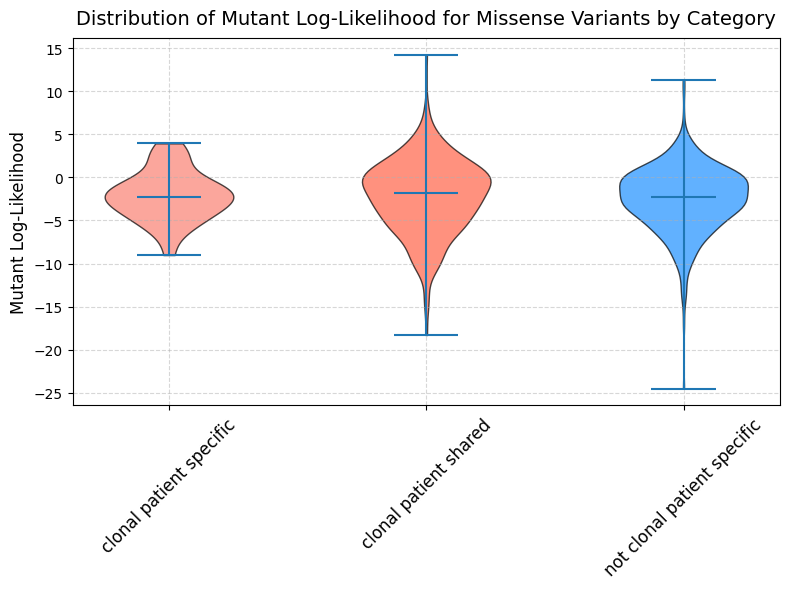

In [22]:
categories = [
    'clonal patient specific',
    'clonal patient shared',
    'not clonal patient specific',
    'not clonal patient shared'
]

# Prepare the data: For each category, extract the 'pllr' values.
# We also filter out categories with no data.
data = []
valid_categories = []
for cat in categories:
    cat_data = results_dt[results_dt['Category'] == cat]['pllr'].dropna()
    if not cat_data.empty:
        data.append(cat_data)
        valid_categories.append(cat)
    else:
        print(f"Category '{cat}' has no data and will be skipped.")

plt.figure(figsize=(8, 6))  # Adjust figure size for clarity

# Create the violin plot for the non-empty categories.
parts = plt.violinplot(data, showmedians=True, vert=True)

# Customize the appearance of each violin body.
# Use a list of colors; if fewer colors than categories, colors will repeat.
colors = ['salmon', 'tomato', 'dodgerblue', 'skyblue']
for i, body in enumerate(parts['bodies']):
    body.set_facecolor(colors[i % len(colors)])
    body.set_edgecolor('black')
    body.set_alpha(0.7)

# Set X-axis ticks with the valid category names.
plt.xticks(range(1, len(valid_categories) + 1), valid_categories, fontsize=12, rotation=45)

# Add title and labels.
plt.title('Distribution of Mutant Log-Likelihood for Missense Variants by Category', fontsize=14, pad=10)
plt.ylabel('Mutant Log-Likelihood', fontsize=12)

# Add grid lines.
plt.grid(True, linestyle='--', alpha=0.5)

# Adjust layout and display the plot.
plt.tight_layout()
plt.show()


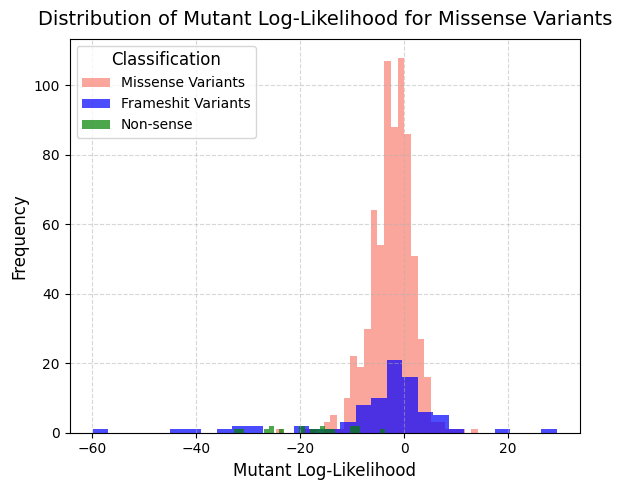

In [12]:
import matplotlib.pyplot as plt

# Filter the DataFrame for benign and pathogenic missense variants
sub_filter = (
    results_dt['classification'].str.contains('Substituti', case=False, na=False) 
)

frameshit_filter = (
    results_dt['classification'].str.contains('FrameShift', case=False, na=False) 
)

non_sense = (
    results_dt['classification'].str.contains('PrematureS', case=False, na=False) 
)


# Extract the delta_log_likelihood values
# benign_data = result_df[benign_filter]['delta_log_likelihood'].dropna()
pathogenic_data = results_dt[sub_filter]['pllr'].dropna()
frameshit_data = results_dt[frameshit_filter]['frameshift_score'].dropna()
non_sense_data = results_dt[non_sense]['stop_gain_score'].dropna()

# Create the histogram plot
plt.figure(figsize=(6, 5))  # Larger figure size for readability
# plt.hist(benign_data, bins=30, alpha=0.7, label='Glioma Variants', color='skyblue') #, edgecolor='black')
plt.hist(pathogenic_data, bins=30, alpha=0.7, label='Missense Variants', color='salmon') #, edgecolor='black')
plt.hist(frameshit_data, bins=30, alpha=0.7, label='Frameshit Variants', color='blue') #, edgecolor='black')
plt.hist(non_sense_data, bins=30, alpha=0.7, label='Non-sense', color='green') #, edgecolor='black')

# Customize the plot
plt.title('Distribution of Mutant Log-Likelihood for Missense Variants', fontsize=14, pad=10)
plt.xlabel('Mutant Log-Likelihood', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.legend(title='Classification', fontsize=10, title_fontsize=12)
plt.grid(True, linestyle='--', alpha=0.5)  # Light grid for reference

# Adjust layout and display
plt.tight_layout()
plt.show()

In [13]:
merged_df[merged_df['Patient'] == 'P161']['file'].unique()

array(['/costellolab/data4/LG3_hg38_output/LG4/mutations/Patient161_mutect2/NOR-Z00141__TUM-Z00142.filtered.vcf',
       '/costellolab/data4/LG3_hg38_output/LG4/mutations/Patient161_mutect2/NOR-Z00141__REC1-Z00143.filtered.vcf'],
      dtype=object)

In [204]:
hist_data = merged_df[merged_df['Histology'].str.contains('Astro', case=False, na=False)]

In [211]:
data_points = hist_data[hist_data['Patient'] == 'P161'] #['pllr'].dropna()

data_points = data_points.drop_duplicates('pos')
# data_points = data_points['pllr'].values
# data_points = np.unique(data_points)
# patient_data.append(data_points)
# count_variants = len(data_points)

count_files = hist_data[hist_data['Patient'] == 'P161']['file'].nunique()

In [213]:
data_points['file'].unique()

array(['/costellolab/data4/LG3_hg38_output/LG4/mutations/Patient161_mutect2/NOR-Z00141__TUM-Z00142.filtered.vcf'],
      dtype=object)

In [142]:
# data_points = hist_data[hist_data['Patient'] == patient].drop_duplicates('pos') #['pllr'].dropna()

In [177]:
len(np.unique(data_points['pllr'].values))

74

In [ ]:
result_df = pd.read_csv('/global/scratch/users/sergiomar10/ESMC_CLINVAR_extended_results_19k_fixed_29700.csv') #ESMC_CLINVAR_extended_resul
result_df 

In [ ]:
result_df['classification'].unique()

In [ ]:
Counter(result_df['classification'])

In [ ]:
import matplotlib.pyplot as plt

# Filter the DataFrame for benign and pathogenic missense variants
benign_filter = (
    result_df['classification'].str.contains('enign', case=False, na=False) & 
    result_df['mc'].str.contains('missense', case=False, na=False)
)
pathogenic_filter = (
    result_df['classification'].str.contains('Patho', case=True, na=False) & 
    result_df['mc'].str.contains('missense', case=False, na=False)
)

# Extract the delta_log_likelihood values
benign_data = result_df[benign_filter]['delta_log_likelihood'].dropna()
pathogenic_data = result_df[pathogenic_filter]['delta_log_likelihood'].dropna()

# Create the histogram plot
plt.figure(figsize=(6, 5))  # Larger figure size for readability
plt.hist(benign_data, bins=30, alpha=0.7, label='Benign', color='skyblue') #, edgecolor='black')
plt.hist(pathogenic_data, bins=30, alpha=0.7, label='Pathogenic', color='salmon') #, edgecolor='black')

# Customize the plot
plt.title('Distribution of Mutant Log-Likelihood for Missense Variants', fontsize=14, pad=10)
plt.xlabel('Mutant Log-Likelihood', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.legend(title='Classification', fontsize=10, title_fontsize=12)
plt.grid(True, linestyle='--', alpha=0.5)  # Light grid for reference

# Adjust layout and display
plt.tight_layout()
plt.show()

In [ ]:
import matplotlib.pyplot as plt

# Filter the DataFrame for benign and pathogenic missense variants
benign_filter = (
    result_df['classification'].str.contains('enign', case=False, na=False) & 
    result_df['mc'].str.contains('missense', case=False, na=False)
)
pathogenic_filter = ( 
    result_df['classification'].str.contains('atho', case=False, na=False) & 
    result_df['mc'].str.contains('nonsense', case=False, na=False) &
    result_df['stop_gain_effect_score'].notna()
)

# Extract the delta_log_likelihood values
benign_data = result_df[benign_filter]['delta_log_likelihood'].dropna()
pathogenic_data = result_df[pathogenic_filter]['stop_gain_effect_score'].dropna()

# Create the histogram plot
plt.figure(figsize=(6, 5))  # Larger figure size for readability
plt.hist(benign_data, bins=30, alpha=0.7, label='Benign', color='skyblue' )#, edgecolor='black')
plt.hist(pathogenic_data, bins=30, alpha=0.7, label='Pathogenic', color='salmon') #, edgecolor='black')

# Customize the plot
plt.title('Distribution of Mutant Log-Likelihood for Nonsense Variants', fontsize=14, pad=10)
plt.xlabel('Mutant Log-Likelihood', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.legend(title='Classification', fontsize=10, title_fontsize=12)
plt.grid(True, linestyle='--', alpha=0.5)  # Light grid for reference

# Adjust layout and display
plt.tight_layout()
plt.show()

In [ ]:
import seaborn as sns

In [ ]:
missense_df

In [ ]:
missense_df['protein'].nunique()

In [ ]:
# Filter for missense variants and drop NaN values in delta_log_likelihood
missense_df = result_df[result_df['mc'] == 'missense'].dropna(subset=['delta_log_likelihood'])

# Map classifications to match the study's categories
classification_mapping = {
    'Benign': 'Benign',
    'Likely_benign': 'Likely benign',
    'Pathogenic': 'Pathogenic',
    'Likely_pathogenic': 'Likely pathogenic',
    # Combine Benign/Likely benign and Pathogenic/Likely pathogenic if needed
    'Conflicting_interpretations_of_pathogenicity': 'Uncertain significance'
}
missense_df['classification'] = missense_df['classification'].map(classification_mapping).fillna('Uncertain significance')

# Group similar classifications for the plot (optional, depending on data)
missense_df['classification_grouped'] = missense_df['classification'].replace({
    'Benign': 'Benign',
    'Likely benign': 'Likely benign',
    'Pathogenic': 'Pathogenic',
    'Likely pathogenic': 'Likely pathogenic',
    'Uncertain significance': 'Uncertain significance'
})

# Define custom colors matching the study (blue for benign, orange for pathogenic, gray for uncertain)
palette = {
    'Benign': '#4ba9c8',  # Light blue
    'Likely benign': '#ADD8E6',  # Light blue
    'Pathogenic': '#FFA500',  # Light orange
    'Likely pathogenic': '#FFA500',  # Light orange
    'Uncertain significance': '#808080'  # Gray
}

order = ['Benign', 'Likely benign', 'Likely pathogenic', 'Pathogenic', 'Uncertain significance']


# Set up the plot
plt.figure(figsize=(12, 6))
sns.violinplot(x='classification_grouped', y='delta_log_likelihood', data=missense_df, 
               palette=palette, inner='quartile', cut=0, width=0.8, order=order)

# Customize the plot
plt.title('ClinVar annotations (~7000 variants in 677 genes)', fontsize=14, pad=15)
plt.xlabel('Clinical Significance', fontsize=12)
plt.ylabel('ESM Cambrian LLR Score', fontsize=12)
plt.xticks(rotation=0, ha='center')  # No rotation, centered labels
plt.ylim(-15, 10)  # Match the y-axis range from the image
plt.grid(True, linestyle='--', alpha=0.3, axis='y')  # Light gray, dashed grid on y-axis
plt.axvline(x=3.5, color='gray', linestyle='--', alpha=0.5)  # Vertical line between benign/pathogenic and uncertain

# Adjust layout and display
plt.tight_layout()
plt.show()

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Example: Load your DataFrame (adjust as needed)
# df = pd.read_csv('your_data.csv')

# Convert classification tuple to string (if necessary)
result_df['classification'] = result_df['classification'].apply(lambda x: x[0] if isinstance(x, tuple) else x)

# ---------------------------
# 1. Histogram of Log Likelihood by Classification
# ---------------------------
plt.figure(figsize=(10, 6))
sns.histplot(data=result_df, x='delta_log_likelihood', hue='classification', bins=30, kde=True)
plt.title("Histogram of Log Likelihood by Classification")
plt.xlabel("Log Likelihood")
plt.ylabel("Frequency")
plt.legend(title="Classification")
plt.show()

# ---------------------------
# 2. Box Plot of Log Likelihood by Classification
# ---------------------------
plt.figure(figsize=(8, 6))
sns.boxplot(x='classification', y='delta_log_likelihood', data=result_df)
plt.title("Box Plot of Log Likelihood by Classification")
plt.xlabel("Classification")
plt.ylabel("Log Likelihood")
plt.show()


In [ ]:
import pandas as pd
import pysam
from Bio.Seq import Seq
import re

# Define file paths
gtf_path = "/global/scratch/users/sergiomar10/data/GCF_000001405.40_GRCh38.p14_genomic.gtf"
vcf_path = "/global/scratch/users/sergiomar10/data/clinvar_20210302.vcf.gz"
fasta_path = "/global/scratch/users/sergiomar10/data/GCF_000001405.40_GRCh38.p14_genomic.fna"

# -----------------------------------------------------
# 1. Load and parse the GTF file with pandas
gtf_cols = ["chrom", "source", "feature", "start", "end", "score", "strand", "frame", "attributes"]
gtf_df = pd.read_csv(gtf_path, sep="\t", comment='#', header=None, names=gtf_cols)

# Keep only CDS features
cds_df = gtf_df[gtf_df['feature'] == 'CDS'].copy()

# Function to extract transcript_id from the attributes column
def extract_transcript_id(attr):
    match = re.search('transcript_id "([^"]+)"', attr)
    if match:
        return match.group(1)
    return None

cds_df['transcript_id'] = cds_df['attributes'].apply(extract_transcript_id)

# Group CDS features by transcript
# We build a dictionary: transcript_id -> list of exons (each as a dict with chrom, start, end, strand)
cds_by_transcript = {}
for transcript, group in cds_df.groupby("transcript_id"):
    # Use the strand from the first row (assumed consistent across exons)
    strand = group.iloc[0]['strand']
    # For plus strand, sort exons by start; for minus, sort in reverse genomic order
    if strand == "+":
        group_sorted = group.sort_values("start")
    else:
        group_sorted = group.sort_values("start", ascending=False)
    exons = []
    for _, row in group_sorted.iterrows():
        exon = {
            "chrom": row["chrom"],
            "start": int(row["start"]),
            "end": int(row["end"]),
            "strand": row["strand"]
        }
        exons.append(exon)
    cds_by_transcript[transcript] = exons

# -----------------------------------------------------
# 2. Helper functions to rebuild the CDS sequence and find overlapping transcripts

def get_transcript_cds_with_mapping(transcript_id, exons, fasta):
    """
    Given a transcript's exons (list of dicts with chrom, start, end, strand)
    and an open pysam FASTA file, return:
      - full CDS sequence as a string,
      - a mapping list where each CDS index maps to (chrom, genomic_position),
      - the strand.
    """
    strand = exons[0]["strand"]
    cds_seq = ""
    mapping = []
    for exon in exons:
        chrom = exon["chrom"]
        start = exon["start"]
        end = exon["end"]
        # pysam FASTA is 0-based so subtract 1 from start
        seq = fasta.fetch(chrom, start - 1, end)
        if strand == "-":
            # For the minus strand, reverse complement the exon sequence
            seq = str(Seq(seq).reverse_complement())
            # Build mapping in reverse order
            positions = [(chrom, pos) for pos in range(end, start - 1, -1)]
        else:
            positions = [(chrom, pos) for pos in range(start, end + 1)]
        cds_seq += seq
        mapping.extend(positions)
    return cds_seq, mapping, strand

def get_transcripts_overlapping_variant(chrom, pos, cds_by_transcript):
    """
    Return a list of transcript IDs where the variant (chrom, pos) falls within at least one CDS exon.
    """
    overlapping = []
    for transcript, exons in cds_by_transcript.items():
        for exon in exons:
            if exon["chrom"] == chrom and exon["start"] <= pos <= exon["end"]:
                overlapping.append(transcript)
                break  # if one exon overlaps, no need to check further for this transcript
    return overlapping

# -----------------------------------------------------
# 3. Open FASTA and VCF files using pysam
fasta = pysam.FastaFile(fasta_path)

In [ ]:
vcf = pysam.VariantFile(vcf_path)

records = []
variant_count = 0  # To count the number of processed variants

# Map from common numeric/letter chromosome IDs (as found in VCF) 
# to the full NCBI contig names in the FASTA
chrom_map = {
    "1":  "NC_000001.11",
    "2":  "NC_000002.12",
    "3":  "NC_000003.12",
    "4":  "NC_000004.12",
    "5":  "NC_000005.10",
    "6":  "NC_000006.12",
    "7":  "NC_000007.14",
    "8":  "NC_000008.11",
    "9":  "NC_000009.12",
    "10": "NC_000010.11",
    "11": "NC_000011.10",
    "12": "NC_000012.12",
    "13": "NC_000013.11",
    "14": "NC_000014.9",
    "15": "NC_000015.10",
    "16": "NC_000016.10",
    "17": "NC_000017.11",
    "18": "NC_000018.10",
    "19": "NC_000019.10",
    "20": "NC_000020.11",
    "21": "NC_000021.9",
    "22": "NC_000022.11",
    "X":  "NC_000023.11",
    "Y":  "NC_000024.10",
    "MT": "NC_012920.1",  # Mitochondrial DNA
}

In [ ]:
variant_count = 0  # To count the number of processed variants
records = []

for x, rec in enumerate(vcf.fetch()):
    # Filter based on clinical significance: only process variants that are Pathogenic or Benign.
    # (Assumes that the 'CLNSIG' field is present and contains strings like "Pathogenic" or "Benign")
    clnsig = rec.info.get('CLNSIG')
    if clnsig is None or not any(sig in {"Pathogenic", "Benign"} for sig in clnsig):
        continue

    # print(rec.chrom, rec.pos, rec.ref, rec.alts, clnsig)

    chrom = rec.chrom
    pos  = rec.pos
    ref = rec.ref
    alts = rec.alts

    # Map chromosome names if needed
    if chrom in chrom_map:
        chrom = chrom_map[chrom]
    
    transcripts = get_transcripts_overlapping_variant(chrom, pos, cds_by_transcript)

    if not transcripts:
        continue  # Skip non-coding variants

    # Process each overlapping transcript
    for transcript in transcripts:
        exons = cds_by_transcript[transcript]
        cds_seq, mapping, strand = get_transcript_cds_with_mapping(transcript, exons, fasta)
        
        # Confirm the variant's genomic coordinate is part of the CDS mapping
        if (chrom, pos) not in mapping:
            continue

        cds_index = mapping.index((chrom, pos))
        
        # Construct the mutated CDS sequence.
        # Note: This example assumes a simple SNP (i.e. ref and alt of length 1).
        mutated_seq = cds_seq[:cds_index] + rec.alts[0] + cds_seq[cds_index + 1:]
        
        # Translate the CDS sequences into proteins.
        ref_protein = str(Seq(cds_seq).translate(to_stop=False))
        mut_protein = str(Seq(mutated_seq).translate(to_stop=False))

        if len(mut_protein) < 10:
            break
        
        residue_index = cds_index // 3


        record = {
            "chrom": chrom,
            "pos": pos,
            "transcript": transcript,
            "mutated_residue": residue_index,
            "cds_index": cds_index,
            "cds_seq": ref_protein,
            "mutated_seq": mut_protein,
            "strand": strand,
            "clnsig": clnsig,
        }
        records.append(record)

    variant_count += 1

    if x > 1000:
        break

print("Processed", variant_count, "variants")
print("Recorded", len(records), "coding variants with relevant clinical significance.")

In [ ]:
results = []

# Loop over each variant record (each protein sequence)
for idx, row in variants_df.iterrows():
    # Get the protein sequence from the record. (Here we use the mutated sequence.)
    protein_seq = row['mutated_seq']
    protein = ESMProtein(sequence=protein_seq)
    
    # -------------------------------
    # 1. Encode the protein and determine valid positions
    # -------------------------------
    # Encode the protein into token IDs.
    protein_tensor = model.base_model.encode(protein)
    token_ids = protein_tensor.sequence  # Tensor of token IDs
    
    # For many protein tokenizers the first and last tokens are special (BOS/EOS).
    # We assume each remaining token corresponds 1:1 with an amino acid.
    valid_positions = []
    original_tokens = []
    for pos in range(1, len(token_ids) - 1):
        token_id = int(token_ids[pos].item())
        token_str = model.base_model.tokenizer.decode([token_id]).strip()
        if token_str in aa_to_idx:
            valid_positions.append(pos)
            original_tokens.append(token_str)
    # If tokenization is truly 1:1, valid_positions will simply be [1, 2, ..., len(token_ids)-2].
    valid_positions_tensor = torch.tensor(valid_positions, device=device)
    
    # -------------------------------
    # 2. Mask all valid positions and get predictions
    # -------------------------------
    with torch.no_grad():
        # The model returns logits for each masked token position.
        masked_logits, _ = model(protein, mask_positions=valid_positions_tensor)
    
    # Instead of converting logits to probabilities via softmax,
    # we use log_softmax to obtain log likelihoods (LLR).
    llr = F.log_softmax(masked_logits, dim=-1)  # Shape: (n_masked_positions, vocab_size)
    
    # -------------------------------
    # 3. Extract log likelihoods for the standard 20 amino acids
    # -------------------------------
    # Ensure the amino acids are ordered consistently.
    std_aa_pairs = sorted(aa_to_idx.items(), key=lambda x: x[1])
    std_aas = [aa for aa, idx in std_aa_pairs]
    std_indices = [idx for aa, idx in std_aa_pairs]
    
    # Select only the columns corresponding to the standard amino acids.
    # llr_matrix will have shape (n_masked_positions, 20)
    llr_matrix = llr[:, std_indices].cpu().numpy()
    
    # -------------------------------
    # 4. Look up the log likelihood at the mutated residue position
    # -------------------------------
    # The mutated residue is assumed to be one-indexed (e.g. 394 means the 394th amino acid).
    mut_residue = row['mutated_residue']
    
    # Check that the mutated residue position is among our valid positions.
    # Because valid_positions are the token indices corresponding to the protein residues,
    # and assuming a 1:1 mapping, they should contain the mutated residue (if it is not a special token).
    if mut_residue in valid_positions:
        # Find its index in the list of valid positions.
        pos_idx = valid_positions.index(mut_residue)
        # Look up the amino acid at that position in the protein sequence.
        aa_at_pos = protein_seq[mut_residue - 1]  # Convert one-indexed to 0-indexed.
        if aa_at_pos in std_aas:
            aa_idx = std_aas.index(aa_at_pos)
            log_likelihood = llr_matrix[pos_idx, aa_idx]
        else:
            log_likelihood = None
    else:
        log_likelihood = None
    
    # -------------------------------
    # 5. Record the result for this variant
    # -------------------------------
    results.append({
        "protein": row["transcript"],
        "classification": row["clnsig"],
        "mutated_residue": mut_residue,
        "mutated_aa": protein_seq[mut_residue - 1] if mut_residue <= len(protein_seq) else None,
        "log_likelihood": log_likelihood  # This is your LLR for the mutated amino acid.
    })

# Create a DataFrame with the collected results.
result_df = pd.DataFrame(results)